# Colour Magnitude Diagram

We read the photometric catalogs of the science frames, and draw a colour magnitude diagram.

You can download this page as a {download}`jupyter notebook <./CMD.ipynb>` file.

In [25]:
import dataredconfig

import numpy as np
import astropy
import astropy.visualization
from astropy import units as u

%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt



In [26]:
# Where the photometry catalogs are:
photometry_dir = dataredconfig.work_dir / "PHOTOMETRY"

object_to_select = "M 37"

catalog_filepaths = sorted(list(photometry_dir.glob('*.fits')))
catalogs = []
for catalog_filepath in catalog_filepaths:
    
    #hdul = astropy.io.fits.open(photometry_dir / catalog_files.files[-1])
    #hdul.info()

    catalog = astropy.table.Table.read(catalog_filepath)

    if catalog.meta["OBJECT"] == object_to_select:
        print(f"{catalog_filepath} : {catalog.meta}")
        catalogs.append(catalog)


/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/PHOTOMETRY/2024-03-08_22-04-34_r_-10.00_60.00s_0000.new.fits : OrderedDict([('DATE', '2024-04-22 01:56:20 CEST'), ('DATE-OBS', '2024-03-08T21:04:34.262'), ('EXPTIME', 60.0), ('IMAGETYP', 'LIGHT'), ('AIRMASS', 1.22797865344338), ('PIERSIDE', 'East'), ('FILTER', 'r'), ('OBJECT', 'M 37'), ('FOCUSPOS', 6773), ('FOCTEMP', 10.9), ('RA', 88.0599056676792), ('DEC', 32.5660643632296), ('SET-TEMP', -10.0), ('CCD-TEMP', -10.0), ('GAIN', 30), ('OFFSET', 30)])
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/PHOTOMETRY/2024-03-08_22-05-37_r_-10.00_60.00s_0001.new.fits : OrderedDict([('DATE', '2024-04-22 01:56:30 CEST'), ('DATE-OBS', '2024-03-08T21:05:37.675'), ('EXPTIME', 60.0), ('IMAGETYP', 'LIGHT'), ('AIRMASS', 1.23046486115206), ('PIERSIDE', 'East'), ('FILTER', 'r'), ('OBJECT', 'M 37'), ('FOCUSPOS', 6773), ('FOCTEMP', 10.9), ('RA', 88.0598757732892), ('DEC', 32.5660542777035), ('SET-TEMP', -10.0), ('CCD-TEMP', -10.0), ('GAIN', 30), ('OFFSET', 

In [27]:

filter_names = ("g", "r", "i")
filter_catalogs = []

for filter_name in filter_names:
    print(f"Starting filter {filter_name}")
    this_filter_catalogs = [catalog for catalog in catalogs if catalog.meta["FILTER"] == filter_name]
    this_filter_catalog = astropy.table.dstack(this_filter_catalogs, join_type="exact", metadata_conflicts="silent")
    this_filter_catalog.name = filter_name
    
    
    # Rename columns, adding the filter_name:
    #old_names = tuple(this_filter_catalog.colnames)
    #new_names = tuple([f"{name}_{str(filter_name)}" for name in old_names])
    #print(old_names)
    #print(new_names)
    #this_filter_catalog.rename_columns(old_names, new_names)
    #for name in this_filter_catalog.colnames:
    #    print(name, f"{name}_{str(filter_name)}")
    #    this_filter_catalog.rename_column(name, new_name=f"{name}_{str(filter_name)}")
    #    this_filter_catalog[name].name = "bla"
    #print(this_filter_catalog.colnames)
    #print(this_filter_catalog.meta)
    filter_catalogs.append(this_filter_catalog)

# And we stack these catalogs horizontally into one single table:
cat = astropy.table.hstack(filter_catalogs,
        join_type="exact", metadata_conflicts="silent",
        table_names=filter_names, uniq_col_name='{col_name}_{table_name}'
        )

Starting filter g
Starting filter r
Starting filter i


In [28]:

# Adding a column with the separation between each star and the cluster center

cat["sky_pos"] = cat["sky_centroid_win_r"][:,0]
target_center_pos = astropy.coordinates.SkyCoord(cat.meta["RA"]*u.deg, cat.meta["DEC"]*u.deg)
cat["separation"] = astropy.coordinates.SkyCoord.separation(cat["sky_pos"], target_center_pos)


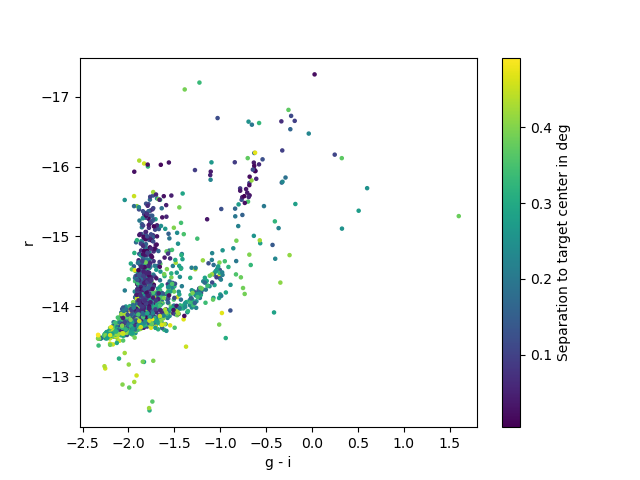

In [29]:
# Quick CMD, with a colorbar indicating the separation between each star and the cluster center

cat["g"] = np.median(-2.5 * np.log10(cat["sum_6_g"].value), axis=1)
cat["r"] = np.median(-2.5 * np.log10(cat["sum_6_r"].value), axis=1)
cat["i"] = np.median(-2.5 * np.log10(cat["sum_6_i"].value), axis=1)

plt.figure()
plt.scatter(
    cat["g"] - cat["i"],
    cat["r"],
    s = 5,
    c = cat["separation"].value
)
plt.gca().invert_yaxis()
plt.colorbar(label=f"Separation to target center in {cat['separation'].unit}")
plt.xlabel("g - i")
plt.ylabel("r")
plt.show()

